# Notebook 03: Simulation of Acetogenic Fermentation in Bubble Column at 30 and 60°C

This notebook is part of the research paper titled:

Optimizing acetogenic CO(2) utilization through metabolic and process engineering highlights the potential of thermophilic bioproduction

This notebook simulates the fermentation of acetogenic growth in a large scale bubble column reactor at two given temperatures, using mass balances as defined in notebook 01, and a thermodynaminc-based black box model of acetogenic growth, building on notebook 02.

Notebook author: Philip J. Gorter de Vries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint

# Define parameters

In [2]:
Tc1 = 30 #Temperature in Celsius
Tc2 = 60 #Temperature in Celsius

SameGrowthRates = True #For the sake of comparisson, the maximum growth rates can be forced to be equal. Otherwise, they are temperature dependant 

#Reaction time
t_rt = 50

#mol fraction of incoming gas
y_co = 0.4 #[mol/mol]
y_co2 = 0.2 #[mol/mol]
y_h2 = 0.38 #[mol/mol]
y_o2 = 0.01 #[mol/mol]
y_n2 = 0.01 #[mol/mol]

#Universal constants:
R = 8.314 # [m^3*Pa/K/mol]

def Kelvin_Celsius(t):
    """
    This function converts Temperature values from Kelvin to degrees Celsius
    """
    return t-273.15

def Celsius_Kelvin(t):
    """
    This function converts Temperature values from degrees Celsius to Kelvin
    """
    return t+273.15

T1 = Celsius_Kelvin(Tc1)
T2 = Celsius_Kelvin(Tc2)
t = np.linspace(0,t_rt,1000)

# Biological Parameters

In [3]:
# for details, view 02_AcetogenYieldTempDependency.ipynb

def µ_max(T):
    if SameGrowthRates == True:
        return 0.4
    else:
        return 46.35 * T * np.exp(-28127.1/(R*T))

def m_NGAM(T):
    return 3.3**(69000/R*(1/298-1/T)) #[kJ/h/CmolX]

m_GAM = 1000 #kJ/CmolX

# Monod substrate saturation constants and inhibtion parameters:
Ks_h2 =  0.0002950 # [mM] https://doi.org/10.1016/j.jece.2022.107281
Ks_co2 =  0.0002950 # [mM] taken from H2
Ks_co = 0.0002950 # [mM] taken from H2
Ki_actt = 800 #mM Inhibition constant for acetone

print(f"at Temperature = {Tc1}°C")
print(f"m_NGAM = {round(m_NGAM(T1),2)} [kJ/h/CmolX]")
print(f"µ_max = {round(µ_max(T1),2)} [/h]")
print(f"m_GAM = {m_GAM} [kJ/CmolX] \n")

print(f"at Temperature = {Tc2}°C")
print(f"m_NGAM = {round(m_NGAM(T2),2)} [kJ/h/CmolX]")
print(f"µ_max = {round(µ_max(T2),2)} [/h]")
print(f"m_GAM = {m_GAM} [kJ/CmolX]")

at Temperature = 30°C
m_NGAM = 1.76 [kJ/h/CmolX]
µ_max = 0.4 [/h]
m_GAM = 1000 [kJ/CmolX] 

at Temperature = 60°C
m_NGAM = 33.39 [kJ/h/CmolX]
µ_max = 0.4 [/h]
m_GAM = 1000 [kJ/CmolX]


# Calculate Gibbs free energy and Enthalpy of Catabolic reaction

<p>Given the reaction stoichiometries:</p>
<p>$ -2 CO_2 - 4 H_2 + CH_3COOH + 2 H_2O $</p>
<p>$ -4 CO - 2 H_2O + CH_3COOH + 2 CO_2 $</p>

In [4]:
S = pd.DataFrame({
    'HomCata':  [0,    -4,  0,    -2,  2,    0,1],
    'CarbCata': [-4,   0,   0,    2,   -2,   0,1],
    'HomAna':   [0,   -2.1, -0.2, -1,  1.5,  1,0],
    'CarbAna':  [-2.1, 0,   -0.2, 1.1, -0.6, 1,0]},
    index=pd.Index(["CO","H2","NH3","CO2","Water","X","Acetate"]))

S

,HomCata,CarbCata,HomAna,CarbAna
CO,0,-4,0.0,-2.1
H2,-4,0,-2.1,0.0
NH3,0,0,-0.2,-0.2
CO2,-2,2,-1.0,1.1
Water,2,-2,1.5,-0.6
X,0,0,1.0,1.0
Acetate,1,1,0.0,0.0


In [5]:
dfGR = pd.read_csv("../Data/EnthalpyGibbs.csv", index_col="Compound")["dfGR"]
dfHR = pd.read_csv("../Data/EnthalpyGibbs.csv", index_col="Compound")["dfHR"]

#Hess's law, as vector multiplication:
DrGR_carb = np.nansum(S.CarbCata * dfGR)
DrGR_hom = np.nansum(S.HomCata * dfGR)
DrHR_carb = np.nansum(S.CarbCata * dfHR)
DrHR_hom = np.nansum(S.HomCata * dfHR)

#Gibbs–Helmholtz equation for temperature correction
def DrGT_carb(T):
    return DrGR_carb * (T/298.15) + DrHR_carb * (1-T/298.15)
def DrGT_hom(T):
    return DrGR_hom * (T/298.15) + DrHR_hom * (1-T/298.15)

print(DrGT_carb(T1),DrGT_hom(T1))
print(DrGT_carb(T2),DrGT_hom(T2))

-231.42360724467548 -150.81437699144723
-232.8252507127285 -140.6406389401308


# Determine anabolic reaction and balance reactions including GAM

<p>Catabolic reaction stoichiometries:</p>

<p>$ 2 CO_2 + 4 H_2 <=> CH_3COOH + 2 H_2O $ 
    <span style="float:right;">(eq. 19)</span> </p>
<p>$ 4 CO + 2 H_2O <=> CH_3COOH + 2 CO_2 $
    <span style="float:right;">(eq. 20)</span> </p>

<p>Anabolic reaction stoichiometries: With an approximated biomass composition of $ CH_{1.8}O_{0.5}N_{0.2} $ and ammonia, $ NH_3 $ as carbon source, a prediction of the stoichiometry for the biomass formation reaction can be made by balancing out all elements in each of the reactions:</p>

<p>With an apporximated biomass composition of $ CH_{1.8}O_{0.5}N_{0.2} $ and ammonia, $ NH_3 $ as carbon source, a prediction of the stoichiometry for the biomass formation reaction can be made by balancing out all elements in each of the reactions:</p>

<p>$ -r_{CO2} CO_2 - r_{H} H_2 - r_{Am} NH_3 + CH_{1.8}O_{0.5}N_{0.2} + r_{W} H_2O = 0$ </p>
<p>$ -r_{CO} CO - r_{W} H_2O - r_{Am} NH_3 + CH_{1.8}O_{0.5}N_{0.2} + r_{CO2} CO_2 = 0$</p>

Which results in:

<p>$ CO_2 + 2.1 H_2 + 0.2 NH_3 <=> CH_{1.8}O_{0.5}N_{0.2} + 1.5 H_2O$
    <span style="float:right;">(eq. 21)</span>  </p>
<p>$ 2.1 CO + 0.6 H_2O + 0.2 NH_3 <=> CH_{1.8}O_{0.5}N_{0.2} + 1.1 CO_2$
    <span style="float:right;">(eq. 22)</span> </p>
    
    
With the corrected Gibbs energy of reaction and the the growth-associated maintenance requirement being determined, the next step is to express the overall reaction stoichiometry. This is done by balancing the catabolic and anabolic reactions, so that the Gibbs free energy of the anabolic reactions ($\Delta _r G$) satifies the energy needs of the catabolic reaction ($m_{GAM}$). $\Delta _r G$ is expressed per mol acetate produced, while $m_{GAM}$ is expressed per mol biomass produced. Therefore both terms are multiplied by the corresponding stoichiometries, which are both 1. The stoichiometry in the overall reaction (S) is calculated for each compound by adding the stoichiometries of the anabolic and catabolic reaction, as balanced with the balancing factor.

<br>
<div style="text-align: center">  $ S_I = \displaystyle S_{I,ana} + \frac{m_{GAM}(T) * S_{X,ana}} {-\Delta _r G(T) * S_{P,cata}} * S_{I,cata} $
</div>

In [6]:
def S_carb(C,T):
    f_m = m_GAM*S.CarbAna["X"]/(-DrGT_carb(T)*S.CarbCata["Acetate"])#*S.CarbCata["Acetate"]/S.CarbCata["CO"])
    return S.CarbAna[C] + S.CarbCata[C] * f_m

def S_hom(C,T):
    f_m = m_GAM*S.HomAna["X"]/(-DrGT_hom(T)*S.CarbCata["Acetate"])#*S.HomCata["Acetate"]/S.HomCata["H2"])
    return S.HomAna[C] + S.HomCata[C] * f_m

In [7]:
print(f'Overall Carboxydotrophic stoichiometry at {Tc1}°C: \n {round(S_carb("CO",T1),2)} CO {round(S_carb("Water",T1),2)} H20 {round(S_carb("NH3",T1),2)} NH3 + {round(S_carb("X",T1),2)} biomass + {round(S_carb("Acetate",T1),2)} CH3COOH + {round(S_carb("CO2",T1),2)} CO2 = 0 \n')
print(f'Overall Homoacetogenic stoichiometry at {Tc1}°C: \n {round(S_hom("CO2",T1),2)} CO2 {round(S_hom("H2",T1),2)} H2 {round(S_hom("NH3",T1),2)} NH3 + {round(S_hom("X",T1),2)} biomass + {round(S_hom("Acetate",T1),2)} CH3COOH + {round(S_hom("Water",T1),2)} H2O = 0 \n')
print(f'Overall Carboxydotrophic stoichiometry at {Tc2}°C: \n {round(S_carb("CO",T2),2)} CO {round(S_carb("Water",T2),2)} H20 {round(S_carb("NH3",T2),2)} NH3 + {round(S_carb("X",T2),2)} biomass + {round(S_carb("Acetate",T2),2)} CH3COOH + {round(S_carb("CO2",T2),2)} CO2 = 0 \n')
print(f'Overall Homoacetogenic stoichiometry at {Tc2}°C: \n {round(S_hom("CO2",T2),2)} CO2 {round(S_hom("H2",T2),2)} H2 {round(S_hom("NH3",T2),2)} NH3 + {round(S_hom("X",T2),2)} biomass + {round(S_hom("Acetate",T2),2)} CH3COOH + {round(S_hom("Water",T2),2)} H2O = 0 \n')

Overall Carboxydotrophic stoichiometry at 30°C: 
 -19.38 CO -9.24 H20 -0.2 NH3 + 1.0 biomass + 4.32 CH3COOH + 9.74 CO2 = 0 

Overall Homoacetogenic stoichiometry at 30°C: 
 -14.26 CO2 -28.62 H2 -0.2 NH3 + 1.0 biomass + 6.63 CH3COOH + 14.76 H2O = 0 

Overall Carboxydotrophic stoichiometry at 60°C: 
 -19.28 CO -9.19 H20 -0.2 NH3 + 1.0 biomass + 4.3 CH3COOH + 9.69 CO2 = 0 

Overall Homoacetogenic stoichiometry at 60°C: 
 -15.22 CO2 -30.54 H2 -0.2 NH3 + 1.0 biomass + 7.11 CH3COOH + 15.72 H2O = 0 



# Construct Black Box models of Moorella

<p>Monod Equation, specific growth rate: </p>
<div style="text-align: center">  $ µ = µ_{max} * 
\displaystyle \frac{c_S}{K_S + c_S} * (1-c_P/c_P^*)$ [$h^{-1}$]
    <span style="float:right;">(eq. 28)</span>
</div>

<p>Pirt kinetics, specific consumption and production rate: </p>
<br>
<div style="text-align: center">  $ q_i = \displaystyle \frac{µ}{Y_{Xi}} + m_{NGAM,i} $ [$h^{-1}$]
    <span style="float:right;">(eq. 29)</span>
</div>
<br>
<div style="text-align: center">  $ m_{NGAM,i} = 
\displaystyle \frac{m_{NGAM}}{-\Delta _r G^T * Y_{PS,cata}}$ [$h^{-1}$]
    <span style="float:right;">(eq. 30)</span>
</div>

Where:
- $Y_{IJ}$: Yield of compound I on J
- $µ$: growth rate (/h)
- $c_I$: concentration of compound I (mM)
- $K_S$: Monod substrate saturation constant (mM)
- $K_{iP}$: Product inhibition constant (mM)
- $m_{NGAM}(T)$: temperature-dependent non-growth-associated maintenance energy requirement ($kJ/h/Cmol_{biomass}$)
- $\Delta _r G(T)$: temperature-dependent Gibbs free energy of reaction per mol product ($kJ/mol$)

subscripts:
 - S: of substrate, electron donor CO or H2
 - X: of biomass 
 - P: of product, acetate
 - ana: in anabolic reaction
 - cata: in catabolic reaction

In [8]:
# Homoacetogenic:
def µ_hom(C_h2, C_co2, C_actt, T):
    return µ_max(T) * C_h2/(Ks_h2+C_h2) * (1-C_actt/Ki_actt)

def q_hom(C, C_h2, C_co2, C_actt, T):
    m_NGAM_Hom = S.HomCata[C]/S.HomCata["H2"] * m_NGAM(T)/(-DrGT_hom(T)*S.HomCata["Acetate"]/S.HomCata["H2"])
    return µ_hom(C_h2, C_co2, C_actt, T)/(S_hom("X",T)/S_hom(C,T)) + m_NGAM_Hom

# Carboxydotrophic:
def µ_carb(C_co, C_actt, T):
    return µ_max(T) * C_co/(Ks_co+C_co) * (1-C_actt/Ki_actt)

def q_carb(C, C_co, C_actt, T):
    m_NGAM_Carb = S.CarbCata[C]/S.CarbCata["CO"] * m_NGAM(T)/(-DrGT_carb(T)*S.CarbCata["Acetate"]/S.CarbCata["CO"])
    return µ_carb(C_co, C_actt, T)/(S_carb("X",T)/S_carb(C,T)) + m_NGAM_Carb

## Bubble column setup parameters:

In [9]:
F_G = 1*10**4 #gas inflow rate (from Steph: (8*10**5 * 8.314 * T)/p_m) [m^3/h]
r = 3 # radius of the reactor [m]
h = 30 # height of the reactor [m]

#deduceable constants
A = math.pi * r**2 #reactor cross-sectional area [m^2]
V_L = A * h * 2/3 #reactor volume, assuming it is 2/3 filled [m^3]
v_gas = F_G/A/3600 #average gas velocity [m/s]
Gas_holdup = 0.6*(v_gas)**0.7 #from Stephanie's paper
V_G = V_L*Gas_holdup

p_t = 101325 # pressure at the top of the reactor [Pa]
p_b = p_t + h * 1000 * 9.81 # pressure at the bottom of the reactor [Pa]
p_m = (p_b-p_t)/math.log(p_b/p_t) # logarithmic mean pressure [Pa]

## Define gas transfer rates as functions

In [10]:
# Load Henry's Law values
DR = pd.read_csv("../Data/HenrysLawData.csv", index_col = "Compound")["DR"]
HR = pd.read_csv("../Data/HenrysLawData.csv", index_col = "Compound")["HR"]
kh = pd.read_csv("../Data/HenrysLawData.csv", index_col = "Compound")["k"]
theta = 1.022 # temperature correction factor

# Kla Temperature correction:
def KLa(C,T):
    return 0.32 * (DR[C]/DR["O2"])**0.5 * v_gas**0.7 * theta**(T-293.15) * 3600 #[1/s]

# Saturation concentration
def Csat(C, T, y):
    return HR[C] * math.e**(kh[C]*(1/T-1/298.15)) * 10**(-5) * p_m * y

# Combine as transfer rate:
def RT(C,T,c,y):
    return KLa(C,T) * (Csat(C,T, y) - c)

## Define mass balances

<br>
<div><b>Box 1:</b> Mass Balances; Accumulation = In - Out + Production - Consumption</div>
<br>
<div>Biomass: &emsp; &emsp; &emsp; &ensp; $ \displaystyle \frac{dc_X}{dt} = µ * c_X $
<div>Acetate: &emsp; &emsp; &emsp; &emsp; $ \displaystyle \frac{dc_{Actt}}{dt} = q_{actt} * c_X$
<div>CO<sub>2</sub>, dissolved:&emsp;&nbsp; $ \displaystyle \frac{dc_{CO_2}}{dt} = q_{CO_2} * c_X + R_{CO_2} $
<div>CO, dissolved: &emsp; &nbsp; $ \displaystyle \frac{dc_{CO}}{dt} = q_{CO} * c_X + R_{CO}$
<div>H<sub>2</sub>, dissolved:&emsp;&emsp;&ensp;&nbsp;$ \displaystyle \frac{dc_{H_2}}{dt} = q_{H_2} * c_X + R_{H_2} $
<div>CO<sub>2</sub>, gas:&emsp;&emsp;&emsp;&emsp;&emsp;$ \displaystyle \frac{dc_{G,CO_{2}}}{dt}=\frac{F_G}{V_G}*(c_{G,CO_2,in}-c_{G,CO_2})-R_{CO_2}*\frac{V_L}{V_G}$
<div>CO, gas:&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;$ \displaystyle \frac{dc_{G,CO}}{dt}=\frac{F_G}{V_G}*(c_{G,CO,in}-c_{G,CO})-R_{CO}*\frac{V_L}{V_G} $
<div>H<sub>2</sub>, gas:&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;&nbsp;$ \displaystyle \frac{dc_{G,H_{2}}}{dt}=\frac{F_G}{V_G}*(c_{G,H_2,in}-c_{G,H_2})-R_{H_2}*\frac{V_L}{V_G}$

In [11]:
def model(z,t):
    X_carb = max(0,z[0])
    X_hom = max(0,z[1])
    c_actt = max(0,z[2])
    c_co2 = max(0,z[3])
    c_co = max(0,z[4])
    c_h2 = max(0,z[5])
    c_n2 = max(0,z[6])
    cG_co2 = max(0,z[7])
    cG_co = max(0,z[8])
    cG_h2 = max(0,z[9])
    cG_n2 = max(0,z[10])
    
    cG_Gas = cG_co2+cG_co+cG_h2+cG_n2

    dXcdt = µ_carb(c_co, c_actt,T) * X_carb
    dXhdt = µ_hom(c_h2, c_co2, c_actt,T) * X_hom
    dacttdt = q_hom("Acetate",c_h2, c_co2, c_actt,T) * X_hom + q_carb("Acetate",c_co, c_actt,T) * X_carb
    dCO2dt = q_hom("CO2",c_h2, c_co2, c_actt,T) * X_hom + q_carb("CO2",c_co, c_actt,T) * X_carb + RT("CO2",T,c_co2,cG_co2/cG_Gas)
    dCOdt = q_carb("CO",c_co, c_actt,T) * X_carb + RT("CO",T,c_co,cG_co/cG_Gas)
    dH2dt = q_hom("H2",c_h2, c_co2, c_actt,T) * X_hom + RT("H2",T,c_h2,cG_h2/cG_Gas)
    dN2dt = RT("N2",T,c_n2,cG_n2/cG_Gas)
    dCO2Gdt = F_G/V_G * (cG_co2_in-cG_co2) - RT("CO2",T,c_co2,cG_co2/cG_Gas) * V_L/V_G
    dCOGdt = F_G/V_G * (cG_co_in-cG_co) - RT("CO",T,c_co,cG_co/cG_Gas) * V_L/V_G
    dH2Gdt = F_G/V_G * (cG_h2_in-cG_h2) - RT("H2",T,c_h2,cG_h2/cG_Gas) * V_L/V_G
    dN2Gdt = F_G/V_G * (cG_n2_in-cG_n2) - RT("N2",T,c_n2,cG_n2/cG_Gas) * V_L/V_G
    
    return [dXcdt,dXhdt,dacttdt,dCO2dt,dCOdt,dH2dt,dN2dt,dCO2Gdt,dCOGdt,dH2Gdt,dN2Gdt]

## Define initial conditions & run simulations

Initialize and run at both temperatures defined at the top of the notebook

Initial gas concentrations: 
 - in the liquid, one can assume that they have reached saturation before starting the experiment
 - in the gas, one can take the inlet concentrations

In [12]:
#initial conditions at T1
T = T1

cG_co2_in = y_co2 * p_m/(R*T)
cG_co_in = y_co * p_m/(R*T)
cG_h2_in = y_h2 * p_m/(R*T)
cG_n2_in = y_n2 * p_m/(R*T)

cG_Gas_0 = cG_co2_in+cG_co_in+cG_h2_in+cG_n2_in

c_co2_0 = Csat("CO2",T,cG_co2_in/cG_Gas_0)
c_co_0 =  Csat("CO",T,cG_co_in/cG_Gas_0)
c_h2_0 =  Csat("H2",T,cG_h2_in/cG_Gas_0)
c_n2_0 =  Csat("N2",T,cG_n2_in/cG_Gas_0)

#z0=[c_n2_0,cG_n2_in]
z0=[0.1,0.1,0,c_co2_0,c_co_0,c_h2_0,c_n2_0,cG_co2_in,cG_co_in,cG_h2_in,cG_n2_in]

#solve ODE
z_T1 = odeint(model,z0,t)

In [13]:
#initial conditions at T2
T = T2

cG_co2_in = y_co2 * p_m/(R*T)
cG_co_in = y_co * p_m/(R*T)
cG_h2_in = y_h2 * p_m/(R*T)
cG_n2_in = y_n2 * p_m/(R*T)

cG_Gas_0 = cG_co2_in+cG_co_in+cG_h2_in+cG_n2_in

c_co2_0 = Csat("CO2",T,cG_co2_in/cG_Gas_0)
c_co_0 =  Csat("CO",T,cG_co_in/cG_Gas_0)
c_h2_0 =  Csat("H2",T,cG_h2_in/cG_Gas_0)
c_n2_0 =  Csat("N2",T,cG_n2_in/cG_Gas_0)

#z0=[c_n2_0,cG_n2_in]
z0=[0.1,0.1,0,c_co2_0,c_co_0,c_h2_0,c_n2_0,cG_co2_in,cG_co_in,cG_h2_in,cG_n2_in]

#solve ODE
z_T2 = odeint(model,z0,t)

# Plot the simulations

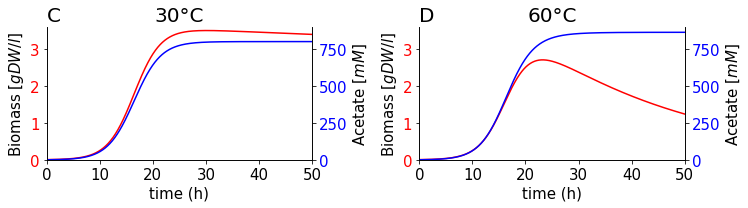

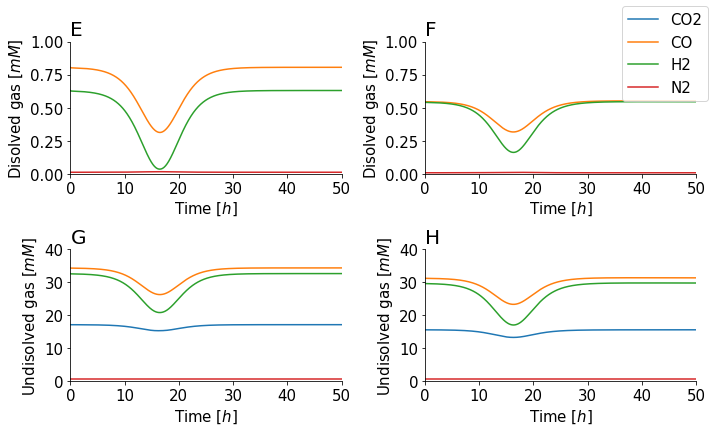

In [14]:
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = False

def two_scales(ax1, time, data1, data2, c1, c2):
    ax2 = ax1.twinx()
    ax1.plot(time, data1, color=c1)
    ax1.set_xlabel('time (h)', fontsize=15)
    ax1.set_ylabel('Biomass [$gDW/l$]', fontsize=15)
    ax1.axis([0, t_rt, 0, 3.6])
    ax1.tick_params(axis='both', which='major', labelsize=15)
    ax2.plot(time, data2, color=c2)
    ax2.set_ylabel('Acetate [$mM$]', fontsize=15)
    ax2.axis([0, t_rt, 0, 900])
    ax2.tick_params(axis='both', which='major', labelsize=15)
    return ax1, ax2

# Create axes
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10.5,3))
ax1, ax1a = two_scales(ax1, t, (z_T1[:,0]+z_T1[:,1])*24.6/1000, z_T1[:,2], 'r', 'b')
plt.title("C", fontdict = {'fontsize': 20}, loc = "left")
plt.title(f"{Tc1}°C", fontdict = {'fontsize': 20}, loc = "center")
ax2, ax2a = two_scales(ax2, t, (z_T2[:,0]+z_T2[:,1])*24.6/1000, z_T2[:,2], 'r', 'b')
plt.title("D", fontdict = {'fontsize': 20}, loc = "left")
plt.title(f"{Tc2}°C", fontdict = {'fontsize': 20}, loc = "center")

# Change color of each axis
def color_y_axis(ax, color):
    """Color your axes."""
    for t in ax.get_yticklabels():
        t.set_color(color)

color_y_axis(ax1, 'r')
color_y_axis(ax1a, 'b')
color_y_axis(ax2, 'r')
color_y_axis(ax2a, 'b')

plt.tight_layout()
plt.show()

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

fig = plt.figure(figsize=(10,6))

plt.subplot(2,2,1)
plt.title("E", fontdict = {'fontsize': 20}, loc = "left")
plt.plot(t,z_T1[:,3])
plt.plot(t,z_T1[:,4])
plt.plot(t,z_T1[:,5])
plt.plot(t,z_T1[:,6])
plt.xlabel(r'Time [$h$]', fontsize=15)
plt.ylabel(r'Disolved gas [$mM$]', fontsize=15)
plt.axis([0, t_rt, 0, 1])
plt.tick_params(axis='both', which='major', labelsize=15)
#plt.legend(['CO2','CO',"H2","N2"],bbox_to_anchor=(0.82, 0.6))

plt.subplot(2,2,3)
plt.title("G", fontdict = {'fontsize': 20}, loc = "left")
plt.plot(t,z_T1[:,7])
plt.plot(t,z_T1[:,8])
plt.plot(t,z_T1[:,9])
plt.plot(t,z_T1[:,10])
plt.xlabel(r'Time [$h$]', fontsize=15)
plt.ylabel(r'Undisolved gas [$mM$]', fontsize=15)
plt.axis([0, t_rt, 0, 40])
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,2)
plt.title("F", fontdict = {'fontsize': 20}, loc = "left")
plt.plot(t,z_T2[:,3])
plt.plot(t,z_T2[:,4])
plt.plot(t,z_T2[:,5])
plt.plot(t,z_T2[:,6])
plt.xlabel(r'Time [$h$]', fontsize=15)
plt.ylabel(r'Disolved gas [$mM$]', fontsize=15)
plt.axis([0, t_rt, 0, 1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(['CO2','CO',"H2","N2"], bbox_to_anchor=(0.7, 0.495), fontsize=15)

plt.subplot(2,2,4)
plt.title("H", fontdict = {'fontsize': 20}, loc = "left")
plt.plot(t,z_T2[:,7])
plt.plot(t,z_T2[:,8])
plt.plot(t,z_T2[:,9])
plt.plot(t,z_T2[:,10])
plt.xlabel(r'Time [$h$]', fontsize=15)
plt.ylabel(r'Undisolved gas [$mM$]', fontsize=15)
plt.axis([0, t_rt, 0, 40])
plt.tick_params(axis='both', which='major', labelsize=15)

fig.tight_layout()
plt.show()

# Plot separately for publication

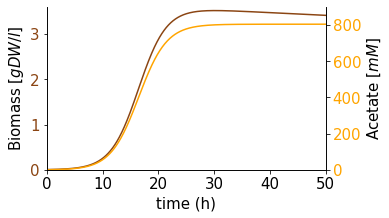

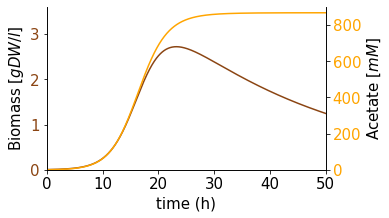

In [15]:
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = False

def two_scales(ax1, time, data1, data2, c1, c2):
    ax2 = ax1.twinx()
    ax1.plot(time, data1, color=c1)
    ax1.set_xlabel('time (h)', fontsize=15)
    ax1.set_ylabel('Biomass [$gDW/l$]', fontsize=15)
    ax1.axis([0, t_rt, 0, 3.6])
    ax1.tick_params(axis='both', which='major', labelsize=15)
    ax2.plot(time, data2, color=c2)
    ax2.set_ylabel('Acetate [$mM$]', fontsize=15)
    ax2.axis([0, t_rt, 0, 900])
    ax2.tick_params(axis='both', which='major', labelsize=15)
    return ax1, ax2

# Change color of each axis
def color_y_axis(ax, color):
    """Color your axes."""
    for t in ax.get_yticklabels():
        t.set_color(color)
    return None

# Create axes
fig, ax = plt.subplots(figsize=(5,3))
ax1, ax2 = two_scales(ax, t, (z_T1[:,0]+z_T1[:,1])*24.6/1000, z_T1[:,2], 'saddlebrown', 'orange')

color_y_axis(ax1, 'saddlebrown')
color_y_axis(ax2, 'orange')
plt.savefig('../Figures/Simulation/30_Biomass')
plt.show()

fig, ax = plt.subplots(figsize=(5.,3))
ax1, ax2 = two_scales(ax, t, (z_T2[:,0]+z_T2[:,1])*24.6/1000, z_T2[:,2], 'saddlebrown', 'orange')
color_y_axis(ax1, 'saddlebrown')
color_y_axis(ax2, 'orange')
plt.savefig('../Figures/Simulation/60_Biomass')
plt.show()

In [16]:
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.size'] = "14"
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 4

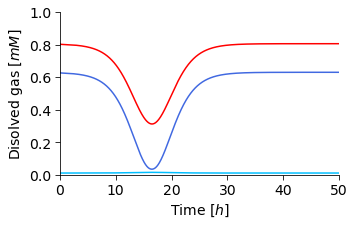

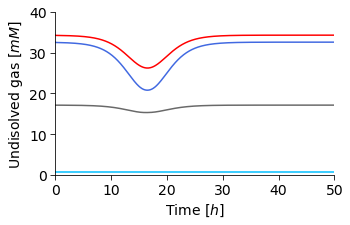

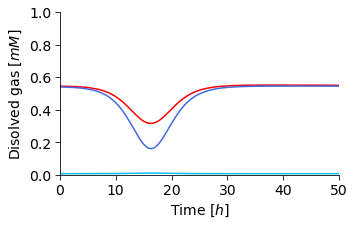

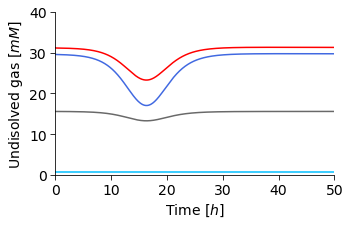

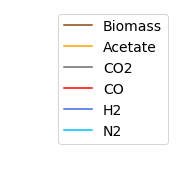

In [17]:
fig = plt.figure(figsize=(5,3))
plt.plot(np.NaN, np.NaN, 'r')
plt.plot(np.NaN, np.NaN)
plt.plot(t,z_T1[:,3], "dimgray")
plt.plot(t,z_T1[:,4], "red")
plt.plot(t,z_T1[:,5], 'royalblue')
plt.plot(t,z_T1[:,6], 'deepskyblue')
plt.xlabel(r'Time [$h$]')
plt.ylabel(r'Disolved gas [$mM$]')
plt.axis([0, t_rt, 0, 1])
plt.savefig('../Figures/Simulation/30_disolved')
plt.show()

fig = plt.figure(figsize=(5,3))
plt.plot(np.NaN, np.NaN, 'r')
plt.plot(np.NaN, np.NaN)
plt.plot(t,z_T1[:,7], 'dimgray')
plt.plot(t,z_T1[:,8], "red")
plt.plot(t,z_T1[:,9], 'royalblue')
plt.plot(t,z_T1[:,10], 'deepskyblue')
plt.xlabel(r'Time [$h$]')
plt.ylabel(r'Undisolved gas [$mM$]')
plt.axis([0, t_rt, 0, 40])
plt.savefig('../Figures/Simulation/30_gas')
plt.show()

fig = plt.figure(figsize=(5,3))
plt.plot(np.NaN, np.NaN, 'r')
plt.plot(np.NaN, np.NaN)
plt.plot(t,z_T2[:,3], 'dimgray')
plt.plot(t,z_T2[:,4], 'red')
plt.plot(t,z_T2[:,5], 'royalblue')
plt.plot(t,z_T2[:,6], 'deepskyblue')
plt.xlabel(r'Time [$h$]')
plt.ylabel(r'Disolved gas [$mM$]')
plt.axis([0, t_rt, 0, 1])
plt.savefig('../Figures/Simulation/60_disolved')
plt.show()

fig = plt.figure(figsize=(5,3))

plt.plot(np.NaN, np.NaN, 'r')
plt.plot(np.NaN, np.NaN)
plt.plot(t,z_T2[:,7], 'dimgray')
plt.plot(t,z_T2[:,8], 'red')
plt.plot(t,z_T2[:,9], 'royalblue')
plt.plot(t,z_T2[:,10], 'deepskyblue')
plt.xlabel(r'Time [$h$]')
plt.ylabel(r'Undisolved gas [$mM$]')
plt.axis([0, t_rt, 0, 40])
plt.savefig('../Figures/Simulation/60_gas')
plt.show()

fig = plt.figure(figsize=(3,3))
plt.axis('off')
plt.plot(np.NaN, np.NaN, 'saddlebrown')
plt.plot(np.NaN, np.NaN, "orange")
plt.plot(np.NaN, np.NaN, "dimgray")
plt.plot(np.NaN, np.NaN, 'red')
plt.plot(np.NaN, np.NaN, 'royalblue')
plt.plot(np.NaN, np.NaN, 'deepskyblue')
plt.legend(['Biomass','Acetate','CO2','CO',"H2","N2"])
plt.savefig('../Figures/Simulation/Legend.svg')
plt.show()